<a href="https://colab.research.google.com/github/Alicia-LB/Music-or-Travel/blob/main/Travel_Insurance_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Travel Claim Insurance Predictions 
-Alicia Lizarraga
* DataSet Source: https://www.kaggle.com/mhdzahier/travel-insurance/version/1

###DataSet Description: 

A third-party travel insurance servicing company that is based in Singapore.

The attributes:

Target: Claim Status (Claim.Status)
Name of agency (Agency)
Type of travel insurance agencies (Agency.Type)
Distribution channel of travel insurance agencies (Distribution.Channel)
Name of the travel insurance products (Product.Name)
Duration of travel (Duration)
Destination of travel (Destination)
Amount of sales of travel insurance policies (Net.Sales)
Commission received for travel insurance agency (Commission)
Gender of insured (Gender)
Age of insured (Age)


###Objective: To see if clients have actually claimed their travel insurance and with which company.

##Importing & Mounting 

In [179]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* Import needed libraries

In [180]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
set_config(display='diagram')

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, classification_report, plot_confusion_matrix, confusion_matrix

* Upload data into notebook using pandas

In [181]:
filename = '/content/travel insurance.csv.zip'
df = pd.read_csv(filename)
df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41


##EDA: Inspect Data

* Used 'info' to get a clear insight into data
* Noticed Gender is missing a lot of data

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63326 entries, 0 to 63325
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                63326 non-null  object 
 1   Agency Type           63326 non-null  object 
 2   Distribution Channel  63326 non-null  object 
 3   Product Name          63326 non-null  object 
 4   Claim                 63326 non-null  object 
 5   Duration              63326 non-null  int64  
 6   Destination           63326 non-null  object 
 7   Net Sales             63326 non-null  float64
 8   Commision (in value)  63326 non-null  float64
 9   Gender                18219 non-null  object 
 10  Age                   63326 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 5.3+ MB


* Another way to find only the missing values

In [183]:
df.isna().sum()

Agency                      0
Agency Type                 0
Distribution Channel        0
Product Name                0
Claim                       0
Duration                    0
Destination                 0
Net Sales                   0
Commision (in value)        0
Gender                  45107
Age                         0
dtype: int64

* The column Gender may impact audience target for which sex might file a claim for travel insurance, but in case of the objective there's not too much relation in how Gender affects the socioeconomic reality of the claim being filed. As well it seems it may have been an optional choice to clients to volunteer their Gender information. So in this case with so many missing, we will drop the column for now, until I can find a better way to exclude them.

In [184]:
df.drop(columns = 'Gender', inplace = True)
df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,41


* Checked for duplicates and dropped

In [185]:
df.duplicated().sum()

8670

In [186]:
df = df.drop_duplicates(keep = False)
df.duplicated().sum()

0

* Visualize only the objects to see if there are any typos

In [187]:
data_types = df.dtypes
str_cols = data_types[ data_types=='object'].index
str_cols

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Claim', 'Destination'],
      dtype='object')

* From a glance it doesn't seem like there are any words or phrases that are inconsistent or misspelled

In [188]:
for col in str_cols:
    print(f'- {col}:')
    print(df[col].value_counts(dropna=False))
    print("\n\n")

- Agency:
EPX    25914
CWT     7719
C2B     6901
JZI     5596
SSI      875
LWC      673
RAB      517
TST      428
ART      317
KML      252
JWT      247
CCR      159
CBH       97
TTW       86
CSR       84
ADM       82
Name: Agency, dtype: int64



- Agency Type:
Travel Agency    35494
Airlines         14453
Name: Agency Type, dtype: int64



- Distribution Channel:
Online     49003
Offline      944
Name: Distribution Channel, dtype: int64



- Product Name:
Cancellation Plan                       13631
2 way Comprehensive Plan                10049
Rental Vehicle Excess Insurance          7719
Basic Plan                               4748
Bronze Plan                              3312
1 way Comprehensive Plan                 2234
Silver Plan                              2036
Value Plan                               1877
Annual Silver Plan                       1034
Ticket Protector                          875
Travel Cruise Protect                     427
Gold Plan                       

* Used 'describe' to see if any numeric values were off
* Age column had a high of 118 years old for max and 0 for min
* Net sales was in the negatives for min
* Duration had -2 in min

* Dropped these specific columns since they didn't make sense

In [189]:
df.describe()

,Duration,Net Sales,Commision (in value),Age
count,49947.000000,49947.000000,49947.000000,49947.000000
mean,54.066991,43.505300,11.054156,39.928604
std,108.678148,50.569755,21.164442,13.007587
min,-2.000000,-389.000000,0.000000,0.000000
25%,12.000000,19.800000,0.000000,34.000000
50%,27.000000,29.700000,0.000000,36.000000
75%,60.000000,53.500000,12.250000,45.000000
max,4881.000000,810.000000,283.500000,118.000000


In [190]:
df.loc[df['Net Sales'] == -389, :]

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Age
16361,C2B,Airlines,Online,Annual Silver Plan,No,364,SINGAPORE,-389.0,97.25,27


In [191]:
df = df.drop(index = 16361)

In [192]:
df.loc[df['Duration'] <= -1, :]

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Age
14943,JZI,Airlines,Online,Basic Plan,No,-2,BANGLADESH,22.0,7.7,118
52587,JZI,Airlines,Online,Basic Plan,No,-1,MALAYSIA,18.0,6.3,118
52588,JZI,Airlines,Online,Basic Plan,No,-1,BRUNEI DARUSSALAM,18.0,6.3,118
56668,JZI,Airlines,Online,Basic Plan,No,-1,INDONESIA,18.0,6.3,118
59528,JZI,Airlines,Online,Basic Plan,No,-1,CHINA,22.0,7.7,118


In [193]:
df = df.drop(index = 14943)
df = df.drop(index = 52587)
df = df.drop(index = 52588)
df = df.drop(index = 56668)
df = df.drop(index = 59528)

In [194]:
df.loc[df['Age'] < 2, :]

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Age
17021,JZI,Airlines,Online,Value Plan,No,2,MALAYSIA,26.0,9.10,1
41993,TST,Travel Agency,Offline,Travel Cruise Protect,No,94,THAILAND,30.0,10.50,0
52109,TST,Travel Agency,Offline,Travel Cruise Protect,No,94,THAILAND,-30.0,10.50,0
57555,C2B,Airlines,Online,Silver Plan,No,10,SINGAPORE,46.8,11.70,1
57748,C2B,Airlines,Online,Silver Plan,No,33,SINGAPORE,74.4,18.60,1
60234,C2B,Airlines,Online,Bronze Plan,No,12,SINGAPORE,16.0,4.00,1
63211,C2B,Airlines,Online,Bronze Plan,No,56,SINGAPORE,86.5,21.63,1


In [195]:
df = df.drop(index = 41993)
df = df.drop(index = 52109)

In [196]:
n_unique = df.nunique()
n_unique[n_unique>2]

Agency                    16
Product Name              26
Duration                 453
Destination              149
Net Sales               1134
Commision (in value)    1030
Age                       88
dtype: int64

* Rechecked 'describe' to see if the numbers made more sense

In [197]:
df.describe()

,Duration,Net Sales,Commision (in value),Age
count,49939.000000,49939.000000,49939.000000,49939.000000
mean,54.064719,43.518096,11.052872,39.922646
std,108.676303,50.535080,21.162579,12.982562
min,0.000000,-357.500000,0.000000,1.000000
25%,12.000000,19.800000,0.000000,34.000000
50%,27.000000,29.700000,0.000000,36.000000
75%,60.000000,53.950000,12.250000,45.000000
max,4881.000000,810.000000,283.500000,118.000000


##Exploratory Data Analysis

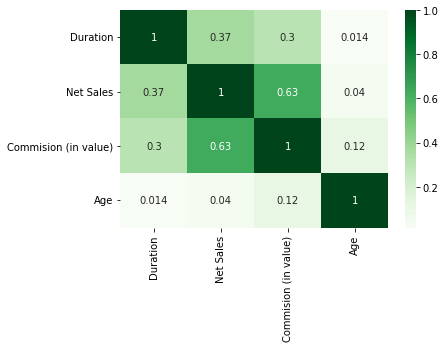

In [198]:
corr = df.corr()
sns.heatmap(corr, cmap = 'Greens', annot = True);

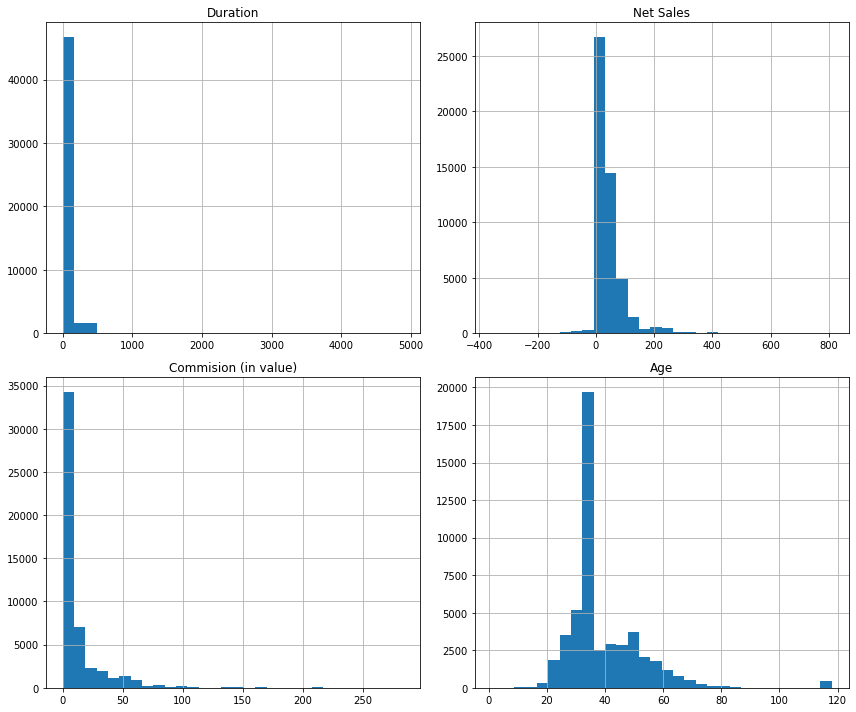

In [199]:
df.hist(figsize=(12,10), bins=30)
plt.tight_layout()
plt.show;

## Modeling: Pre-Processing

* No ordinal values noticeable, so no need to encode prior
* Train test split

In [200]:
y = df['Claim']
X = df.drop(columns = 'Claim')

X_train, y_train, X_test, y_test = train_test_split(X, y, random_state = 3)

* Make column selectors for objects and numbers 

In [201]:
cat_feat = make_column_selector(dtype_include = 'object')
num_feat = make_column_selector(dtype_include = 'number')

* Instantiate StandardScaler and OneHotEncoder
* Instantiate SimpleImputer 

In [202]:
scaler = StandardScaler()
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
mean_imputer = SimpleImputer(strategy = 'mean')
freq_imputer = SimpleImputer(strategy = 'most_frequent')

* Make pipelines for the objects and numbers to use StandardScaler and OneHotEncoder



In [203]:
cat_pipe = make_pipeline(freq_imputer, ohe)
num_pipe = make_pipeline(mean_imputer, scaler)

* Make tuples so objects and numbers don't mix with anything else

In [204]:
cat_tuple = (cat_pipe, cat_feat)
num_tuple = (num_pipe, num_feat)

* Make columns transformer

In [205]:
preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder = 'passthrough')

### Modeling: LogisticRegression

In [225]:
logreg = LogisticRegression(C = 1000)
logreg_pipe = make_pipeline(preprocessor, logreg)
logreg_pipe.fit(X_train,y_train)

ValueError: ignored

### Modeling: KNN

* Instantiate KNeighborsCalssifier
* Make pipeline for knn 

In [215]:
knn = KNeighborsClassifier()
knn_pipe = make_pipeline(preprocessor, knn)
knn_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1f215a9790>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1f215a9e10>)])),
                ('kneighborsclassifier', KNeighborsClassifier())])

* Fit training data

In [216]:
knn_pipe.fit(X_train, y_train)

ValueError: ignored

* Save predictions

In [208]:
knn_train_preds = knn_pipe.predict(X_train)
knn_test_preds = knn_pipe.predict(X_test)

NotFittedError: ignored

* Evaluate KNN model

In [ ]:
print('KNN Training Metrics\n')
evaluate_classification(y_train, knn_train_preds, average='macro')
print('\n')

print('KNN Testing Metrics\n')
evaluate_classification(y_test, knn_test_preds, average='macro')